## Loan approval classifier
In this notebooks a XGBoost loan approval classifier for credit application is trained. Overview of this notebook: 
1. Load data
2. Explanatory data analysis
3. Split features, labels, train, validate and test set
4. Train XGBoost
5. Make prediction
6. Export predictions

To build this classifier an online tutorial was consulted: https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894.

### Load libraries and helper code

In [1]:
import sys
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# xgboost classifier
from xgboost import XGBClassifier

# change path to load data
sys.path.insert(0, "../../data/GermanCredit_dataset/") 

# initialize dataset
from german_dataset import GermanDataset

# helper functions
from helper_functions import *

### 1. Load data
Load one-hot encoded version of German Credit dataset.

In [2]:
gd = GermanDataset(
    
    # default pre-processing
    custom_preprocessing=default_preprocessing
)

Convert to pandas data frame.

In [3]:
df_gd = gd.convert_to_dataframe()[0]
df_gd.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


### 2. Explanatory data analysis

Unbalanced dataset

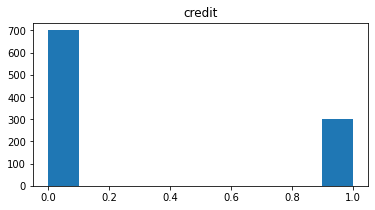

In [4]:
plt.figure(figsize=[6, 3])
plt.hist(df_gd["credit"])
plt.title("credit")
plt.show()

### 3. Split features, labels, train, validate and test set

In [5]:
X = df_gd.drop('credit', 1)
y = df_gd['credit']

# Splitting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

### 4. Train XGBoost

Initialize model and specify model parameters

In [6]:
xgbc = XGBClassifier()
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_to_onehot=None,
              max_delta_step=0, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=1, nthread=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, random_state=0, ...)

In [7]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### 5. Make predictions
Predict

In [8]:
y_hat = xgbc.predict(X_test)

Merging predictions to dataframe

In [9]:
# Converting y_hat from np to df
predictions_col = pd.DataFrame(index=X_test.index)
predictions_col['predicted_class'] = y_hat.tolist()
predictions_col['true_class'] = y_test.tolist()

# Calculating the errors with the absolute value 
predictions_col['errors'] = abs(predictions_col['predicted_class'] - predictions_col['true_class'])

# Adding predictions to test data
entire_dataset = pd.merge(X_test, predictions_col, left_index = True, right_index = True)
entire_dataset.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors
841,21.0,2993.0,3.0,2.0,28.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
956,30.0,3656.0,4.0,4.0,49.0,2.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
544,12.0,1255.0,4.0,4.0,61.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
173,8.0,1414.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0
759,12.0,691.0,4.0,3.0,35.0,2.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1.0,1.0


Confusion matrix

Acc:  0.75


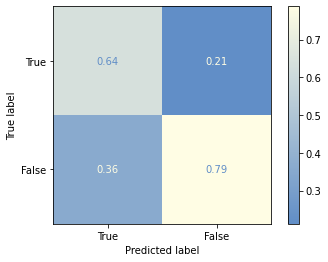

In [11]:
predictions = entire_dataset["predicted_class"]
true = entire_dataset["true_class"]

cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')
cmap0 = mpl.colors.LinearSegmentedColormap.from_list(
        'unevently divided', ['#618EC7','#fffde4'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True', 'False'])
disp.plot(cmap=cmap0)

print('Acc: ', accuracy_score(predictions,true))

### 6. Export data

In [12]:
entire_dataset.to_csv('./pred_XGBoost.csv', index=False)